In [ ]:
import torch.nn as nn
from Vocab_Builder import VocabularyBuilder, DatasetBuilder, ClozeTestDataset
from build_model import LSTMModel
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
from utils import train, index2word
from torch.utils.data import DataLoader

DATASET_PATH = "dataset/main_dataset.csv"
EMBEDDING_DIM = 256
HIDDEN_DIM = 256
NUM_LAYERS = 3
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
BATCH_SIZE = 4096

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab_builder = VocabularyBuilder(DATASET_PATH)
vocab_builder.build_vocab()

vocab_dict = vocab_builder.get_vocab()
index_dict = index2word(vocab_dict)

VOCAB_SIZE = len(vocab_dict.items()) + 3

sentences = vocab_builder.get_sentences_list()

max_len = vocab_builder.get_longest_sentence_length()

print(f"\nVocab size: {VOCAB_SIZE}, max length: {max_len}")

dataset_builder = DatasetBuilder(vocab_dict, max_len=max_len)

x, y = dataset_builder.build_dataset(sentences)

print(f"Total samples: {dataset_builder.total_dataset()}")

sample = dataset_builder.get_sample(0)

_, _, X_test, Y_test = dataset_builder.split_dataset(test_size=0.2)

test_set = ClozeTestDataset(X_test, Y_test)

print(f"Test set size: {len(test_set)}")

model = LSTMModel(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, num_classes=VOCAB_SIZE)
model.load_state_dict(torch.load("trained_model_LSTM.pth"))
model.eval()

model = model.to(device)

Processing row 105046...
Vocab size: 8199, max length: 27
Total samples: 4057647
Test set size: 811529


C:\Users\trung\AppData\Local\Temp\ipykernel_7372\2883542831.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("trained_model_LSTM.pth"))


In [ ]:
test_data_loader = DataLoader(test_set, batch_size=BATCH_SIZE)
word_dict = {}

In [14]:
import sys
with torch.no_grad():
    for batch, (inputs, _) in enumerate(test_data_loader):
        sys.stdout.write(f"\rBatch: {batch + 1}")
        inputs = torch.tensor(inputs).to(device)

        prediction = model(inputs)

        index = torch.argmax(prediction, dim=1)

        for i in index:
            word = index_dict[i.item()]

            if word not in word_dict:
                word_dict[word] = 1
            else: word_dict[word] += 1



Batch: 1

C:\Users\trung\AppData\Local\Temp\ipykernel_7372\2939332614.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs).to(device)


Batch: 199

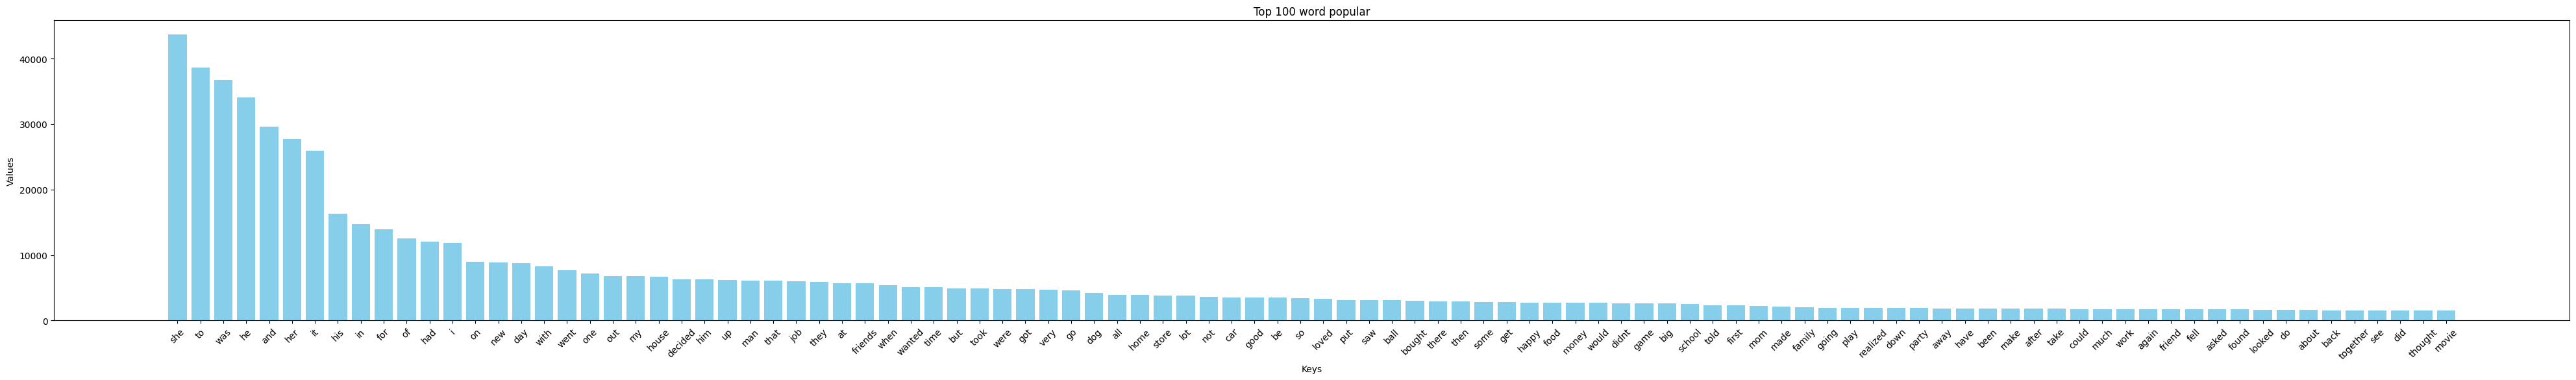

In [19]:
sorted_data = dict(sorted(word_dict.items(), key=lambda item: item[1], reverse=True))

top_100_keys = list(sorted_data.keys())[:100]
top_100_values = list(sorted_data.values())[:100]

plt.figure(figsize=(50, 6))
plt.bar(top_100_keys, top_100_values, color='skyblue')

plt.title('Top 100 word popular')
plt.xlabel('Keys')
plt.ylabel('Values')

plt.xticks(rotation=45)
plt.show()